# LioNets: SMSSpam with TFIDF and Neural Networks -> Classification Task

In this notebook, we present how LioNets can be applied in predictive models using textual data with TFIDF vectorization.

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
import keras
from keras.layers import Dense, LSTM, Dropout, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Input, Model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import Ridge, SGDRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import innvestigate
import innvestigate.utils as iutils
from innvestigate.utils.keras import checks
from lime.lime_text import LimeTextExplainer

import pandas as pd
pd.set_option('max_colwidth',400)
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import OrderedDict
import nltk
import seaborn as sns
from utilities.load_dataset import Load_Dataset
from utilities.evaluation import Evaluation
from lionets import LioNets
from altruist.altruist import Altruist
%matplotlib inline  

Using TensorFlow backend.


In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Load Spam SMS Dataset and split it 80-20 to train and test data

In [4]:
X, y, class_names = Load_Dataset.load_smsspam()
X_train, X_valid, y_train, y_valid =  train_test_split(X,y,test_size=0.2, stratify = y, random_state=0)

We will also load our data without preprocessing to use them in the qualitative experiments

In [5]:
X_r, y_r, class_names = Load_Dataset.load_smsspam(False)
X_trainR, X_validR, y_trainR, y_validR =  train_test_split(X_r,y_r,test_size=0.2, stratify = y, random_state=0)

Load few data to use them as unsupervised

In [6]:
#X_unsup = Load_Dataset.load_unsupervised_data()

Setting the TFIDF vectorizer, with 1K vocabulary 

In [7]:
vec = TfidfVectorizer(analyzer='word',max_features=1000)
vec.fit(X_train)
x_train = vec.transform(X_train)
x_valid = vec.transform(X_valid)
#x_unsup = vec.transform(X_unsup)

Defining the input dimensions

In [8]:
input_dim = len(vec.get_feature_names())
input_dim

1000

Changing the format of the output from 0->0.1 and 1->0.9 in order to help the neural network with the sigmoid function

In [9]:
train_y = [0.1 if i <=0.5 else 0.9 for i in y_train]
valid_y = [0.1 if i <=0.5 else 0.9 for i in y_valid]

We are setting the neural network architecture

In [10]:
check_point = ModelCheckpoint("SMS_Predictor.hdf5", monitor="val_loss", verbose=2,save_best_only=True, mode="auto")
main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')
x = Reshape((1,input_dim))(main_input)
x = LSTM(1000,activation='tanh')(x)
x = Dropout(0.75)(x)
x = Dense(500,activation='tanh')(x)
output_lay = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[main_input], outputs=[output_lay])
model.compile(optimizer="adam",loss=['binary_crossentropy'])

We train the model (we do not use unsupervised data yet)

In [11]:
#model.fit(x_train, train_y, epochs=150, batch_size=64, shuffle=True, validation_data=(x_valid, valid_y), verbose=2, callbacks=[check_point])

We load the best model's weights

In [12]:
weights_file = 'weights/SMS_Predictor.hdf5' # choose the best checkpoint few features
model.load_weights(weights_file) # load it
model.compile(loss="binary_crossentropy", optimizer=Adam())

We are testing the performance of the predictor

In [12]:
temp_pred = model.predict(x_train)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Train:',f1_score(y_train,predictions, average='macro'),f1_score(y_train,predictions, average='weighted'),
      balanced_accuracy_score(y_train,predictions),accuracy_score(y_train,predictions))

temp_pred = model.predict(x_valid)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Train:',f1_score(y_valid,predictions, average='macro'),f1_score(y_valid,predictions, average='weighted'),
      balanced_accuracy_score(y_valid,predictions), accuracy_score(y_valid,predictions))

Train: 0.9990329453832201 0.9995509499720622 0.9983277591973244 0.9995512676688355
Train: 0.9662090493075128 0.9845513065394857 0.9543054455514333 0.9847533632286996


We extract the encoder from the predictor

In [13]:
encoder = Model(input=model.input, output=[model.layers[-2].output])
encoder.trainable = False
encoder.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [14]:
output_layer = model.layers[-1]

In [15]:
output_layer_weigts = output_layer.get_weights()[0]

We encode our data, in order to build the decoder

In [16]:
encoded_x_train = encoder.predict(x_train)
encoded_x_valid = encoder.predict(x_valid)
#encoded_x_unsup = encoder.predict(x_unsup)

We are building now the decoder

In [17]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [18]:
encoded_input = Input(shape=(encoded_x_train[0].shape))

x = Reshape((1,len(encoded_x_train[0])))(encoded_input)
x = LSTM(600, activation='tanh')(x)
x = Dropout(0.7)(x)
x = Dense(800, activation='tanh')(x)
decoded = Dense(input_dim, activation='sigmoid')(x)

decoder = Model(encoded_input,decoded)
decoder.compile(optimizer="Adam",loss=['binary_crossentropy'],metrics=[rmse,'mae'])

checkpoint_name = 'SMS_Decoder.hdf5' #or:'SMS_TFIDF_Decoder.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

We train the decoder, using some unsupervised data as well

In [19]:
#decoder.fit(np.concatenate((encoded_x_train,encoded_x_unsup[12000:13000])), np.concatenate((x_train.toarray(),x_unsup[12000:13000].toarray())), epochs=250, batch_size=250, shuffle=True, validation_data=(encoded_x_valid,x_valid), verbose=2, callbacks=[checkpoint])

We load the best decoder

In [20]:
weights_file = 'weights/SMS_Decoder.hdf5' # choose the best checkpoint few features
decoder.load_weights(weights_file) # load it
decoder.compile(optimizer="Adam",loss=['binary_crossentropy'],metrics=[rmse,'mae'])

In [21]:
decoder.evaluate(encoded_x_train,x_train)

4457/4457 [==============================] - 1s 243us/step


[0.007369646236270379, 0.017966347563295508, 0.0019494198146824688]

In [22]:
decoder.evaluate(encoded_x_valid,x_valid)

1115/1115 [==============================] - 0s 231us/step


[0.009845408352066851, 0.02130000955788544, 0.0023977428607876525]

In [23]:
temp_pred = model.predict(x_train)
predictions1 = [0 if i[0] <=0.5 else 1 for i in temp_pred]
predictions7 = [i[0] for i in temp_pred]

temp_pred = model.predict(x_valid)
predictions2 = [0 if i[0] <=0.5 else 1 for i in temp_pred]
predictions8 = [i[0] for i in temp_pred]

temp_pred = model.predict(decoder.predict(encoder.predict(x_train)))
predictions3 = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Train dec:',f1_score(predictions1,predictions3, average='weighted'),balanced_accuracy_score(predictions1,predictions3),)

temp_pred = model.predict(decoder.predict(encoder.predict(x_valid)))
predictions4 = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Test dec:',f1_score(predictions2,predictions4, average='weighted'),balanced_accuracy_score(predictions2,predictions4))

temp_pred = model.predict(decoder.predict(encoder.predict(x_train)))
predictions5 = [i[0] for i in temp_pred]
print('Train dec mae:',mean_absolute_error(predictions7,predictions5))
temp_pred = model.predict(decoder.predict(encoder.predict(x_valid)))
predictions6 = [i[0] for i in temp_pred]
print('Train dec mae:',mean_absolute_error(predictions8,predictions6))

Train dec: 0.9966521447559124 0.9980574980574981
Test dec: 0.9704458339212495 0.9071245421245422
Train dec mae: 0.006007524
Train dec mae: 0.023022097


We evaluate some decoded instances manually (The first 10 sentences from the train and test set)

Train:

In [24]:
instances_evaluation = decoder.predict(encoded_x_train[:5]) 

We will use a threshold to remove close to zero features

In [25]:
instances_evaluation_threshold = []
for r_m in instances_evaluation:
    a_t = [o if o > 0.045 else 0 for o in r_m]
    instances_evaluation_threshold.append(a_t)
inversed_decoded = vec.inverse_transform(instances_evaluation_threshold)
inversed_original = vec.inverse_transform(x_train[:5])
for i in range(len(inversed_original)):
    print('Original:',' '.join(sorted(inversed_original[i])))
    print(' Decoded:',' '.join(sorted(inversed_decoded[i])))
    print('""""""""""""""""""')

Original: also am but do have in onli pay to
 Decoded: also am but do have in not onli pay to
""""""""""""""""""
Original: come got it me now ok or then thk wan wat
 Decoded: come got it me now ok or then thk wan wat
""""""""""""""""""
Original: at be call club co credit enjoy help info must need or redeem uk video www you
 Decoded: at call club co credit enjoy help info must redeem uk video week www your
""""""""""""""""""
Original: and gt help lt no wa
 Decoded: and gt help lt no wa
""""""""""""""""""
Original: am colleg in
 Decoded: am colleg in
""""""""""""""""""


Test:

In [26]:
instances_evaluation = decoder.predict(encoded_x_valid[:5]) 

We will use a threshold to remove close to zero features

In [27]:
instances_evaluation_threshold = []
for r_m in instances_evaluation:
    a_t = [o if o > 0.045 else 0 for o in r_m]
    instances_evaluation_threshold.append(a_t)
inversed_decoded = vec.inverse_transform(instances_evaluation_threshold)
inversed_original = vec.inverse_transform(x_valid[:5])
for i in range(len(inversed_original)):
    print('Original:',' '.join(sorted(inversed_original[i])))
    print(' Decoded:',' '.join(sorted(inversed_decoded[i])))
    print('""""""""""""""""""')

Original: anyth lar
 Decoded: anyth lar
""""""""""""""""""
Original: been better day each even give god great more never reason thank to
 Decoded: been better day for give god great it more thank the to you
""""""""""""""""""
Original: at cant haha how most so the they tmr what
 Decoded: at haha how just look so the they
""""""""""""""""""
Original: am at be late there will
 Decoded: am at be late there will
""""""""""""""""""
Original: angri be care coz da day dnt have is it luv most nice of serious show take true ur way wen wid
 Decoded: angri care coz da dnt feel in is it luv most nice of serious show some take the true way wen wid
""""""""""""""""""


## LioNets Experiments
Having everything setted up, we are now ready to try our methodology. We first initialize LioNets. LioNets requires a predictor (the classifier itself), an encoder (extracted from the predictor), a decoder, as well as some data (for best results the training data, in order to push the neighbourhood generation through known distribution for the network)

In [28]:
lionetWA = LioNets(model, decoder, encoder, x_train.A, decoder_lower_threshold=0.005, double_detector=True, word_apheresis=True)
lionet = LioNets(model, decoder, encoder, x_train.A, decoder_lower_threshold=0.005, double_detector=True, word_apheresis=False)
transparent_model = Ridge(alpha=0.01,fit_intercept=True,random_state=0)

temp_instance.A[0] for a TFIDF array to be an array

In [13]:
import random 
#random.seed(2000)
random.seed(7777)
train = np.array(random.sample(X_train,200))#200
valid = np.array(random.sample(X_valid,200))
train.shape, valid.shape

((200,), (200,))

Let's calculate the fidelity of Lime and LioNets

In [35]:
split_expression = lambda s: re.split(r'\W+', s)
explainer = LimeTextExplainer(class_names=class_names, split_expression=split_expression)
def lime_predict(text):
    texts = vec.transform(text)
    a = model.predict(texts)
    b = 1 - a 
    return np.column_stack((b,a))

In [ ]:
def lime(text):
    explanation = explainer.explain_instance(text_instance=text, classifier_fn=lime_predict)
    weights = OrderedDict(explanation.as_list())
    lime_w = dict(zip(list(weights.keys()), list(weights.values())))
    weights = []
    keys = lime_w.keys()
    for f in vec.get_feature_names():
        if f in keys:
            weights.append(lime_w[f])
        else:
            weights.append(0)
    return np.array([weights]) #This is because lime interprets class with label 1

In [ ]:
def fi_lime(text):
    explanation = explainer.explain_instance(text_instance=text, classifier_fn=lime_predict)
    local_pred = explanation.local_pred[0]
    return local_pred #This is because lime interprets class with label 1
def fi_lionets(text):
    t_text = vec.transform(np.array([text]))[0].A[0]
    weights, res, loc_res = lionet.explain_instance(t_text,10000,transparent_model)
    return loc_res
def fi_lionetsWA(text):
    t_text = vec.transform(np.array([text]))[0].A[0]
    weights, res, loc_res = lionetWA.explain_instance(t_text,7000,transparent_model)
    return loc_res

In [ ]:
evaluator = Evaluation(model.predict,None,vec.transform,True)

In [ ]:
fidelity = evaluator.fidelity(train, [fi_lime, fi_lionets, fi_lionetsWA], class_n=0)
print('Train:')
print('  Lime fidelity:', fidelity[0][0])
print('  LioNets fidelity:', fidelity[1][0])
print('  LioNetsWA fidelity:', fidelity[2][0])

In [ ]:
fidelity = evaluator.fidelity(valid, [fi_lime, fi_lionets, fi_lionetsWA], class_n=0)
print('Valid:')
print('  Lime fidelity:', fidelity[0][0])
print('  LioNets fidelity:', fidelity[1][0])
print('  LioNetsWA fidelity:', fidelity[2][0])

Let's calculate non zero weights

In [ ]:
Xs = iutils.to_list(model.outputs)
softmax_found = False
ret = []
for x in Xs:
    layer, node_index, tensor_index = x._keras_history
    if checks.contains_activation(layer, activation="sigmoid"):
        softmax_found = True
        if isinstance(layer, keras.layers.Activation):
            ret.append(layer.get_input_at(node_index))
        else:
            layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(layer)
            ret.append(layer_wo_act(layer.get_input_at(node_index)))

In [ ]:
embedding_encoder = Sequential()
for i in range(0,2):
    print(model.layers[i])
    embedding_encoder.add(model.layers[i])
embedding_encoder.trainable = False

In [ ]:
model2 = Model(input=model.input, output=ret)
model2.trainable = False
model2.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [ ]:
analyzer = innvestigate.create_analyzer('input_t_gradient',model2)
analyzerLRP = innvestigate.create_analyzer('lrp.epsilon',model2)

In [ ]:
feature_names = vec.get_feature_names()
def fi_GxI(text):
    t_text = vec.transform(np.array([text]))[0].A[0]
    ooo = analyzer.analyze(np.array([t_text]))[0]
    return [ooo][0]
def fi_LRP(text):
    t_text = vec.transform(np.array([text]))[0].A[0]
    ooo = analyzerLRP.analyze(np.array([t_text]))[0]
    ooo = ooo*t_text #only on lrp
    return [ooo][0]
def fi_lime(text):
    return lime(text)[0] #This is because lime interprets class with label 1
def fi_lionets(text):
    t_text = vec.transform(np.array([text]))[0].A[0]
    weights, res, loc_res = lionet.explain_instance(t_text,10000,transparent_model)
    weights=weights*t_text
    return weights
def fi_lionetsWA(text):
    t_text = vec.transform(np.array([text]))[0].A[0]
    weights, res, loc_res = lionetWA.explain_instance(t_text,7000,transparent_model)
    weights=weights*t_text
    return weights

In [ ]:
non_zero = evaluator.non_zero_weights(train, [fi_GxI, fi_LRP, fi_lime, fi_lionets, fi_lionetsWA])
print('Train:')
print('  GxI Non Zero:', non_zero[0][0])
print('  LRP Non Zero:', non_zero[1][0])
print('  Lime Non Zero:', non_zero[2][0])
print('  LioNets Non Zero:', non_zero[3][0])
print('  LioNetsWA Non Zero:', non_zero[4][0])

In [ ]:
non_zero = evaluator.non_zero_weights(valid, [fi_GxI, fi_LRP, fi_lime, fi_lionets, fi_lionetsWA])
print('Valid:')
print('  GxI Non Zero:', non_zero[0][0])
print('  LRP Non Zero:', non_zero[1][0])
print('  Lime Non Zero:', non_zero[2][0])
print('  LioNets Non Zero:', non_zero[3][0])
print('  LioNetsWA Non Zero:', non_zero[4][0])

Let's calculate robustness

In [ ]:
robustness = evaluator.robustness(train,[fi_lime, fi_GxI, fi_LRP, fi_lionets, fi_lionetsWA], vec.get_feature_names())
print('Train:')
print('  Lime Robustness:', robustness[0])
print('  GxI Robustness:', robustness[1])
print('  LRP Robustness:', robustness[2])
print('  LioNets Robustness:', robustness[3])
print('  LioNetsWA Robustness:', robustness[4])

In [ ]:
robustness = evaluator.robustness(valid,[fi_lime, fi_GxI, fi_LRP, fi_lionets, fi_lionetsWA], vec.get_feature_names())
print('Valid:')
print('  Lime Robustness:', robustness[0])
print('  GxI Robustness:', robustness[1])
print('  LRP Robustness:', robustness[2])
print('  LioNets Robustness:', robustness[3])
print('  LioNetsWA Robustness:', robustness[4])

Let's calculate Altruist Score

In [ ]:
def lime(text):
    explanation = explainer.explain_instance(text_instance=text, classifier_fn=lime_predict)
    weights = OrderedDict(explanation.as_list())
    lime_w = dict(zip(list(weights.keys()), list(weights.values())))
    weights = []
    keys = lime_w.keys()
    for f in vec.get_feature_names():
        if f in keys:
            weights.append(lime_w[f])
        else:
            weights.append(0)
    return np.array([weights]) #This is because lime interprets class with label 1

def fi_GxI(X_t, prediction, model):
    ooo = analyzer.analyze(np.array([X_t]))[0]
    return [ooo][0]
def fi_LRP(X_t, prediction, model):
    ooo = analyzerLRP.analyze(np.array([X_t]))[0]
    ooo = ooo*X_t #only on lrp
    return [ooo][0]
global ccount
ccount = 0
def fi_lime(t, prediction, model):
    global ccount
    expl = lime(train[ccount])[0]
    ccount = ccount+1
    return expl
def fi_lionets(X_t, prediction, model):
    weights, res, loc_red = lionet.explain_instance(X_t,10000,transparent_model)
    weights=weights*X_t
    return weights
def fi_lionetsWA(X_t, prediction, model):
    weights, res, loc_red = lionetWA.explain_instance(X_t,7000,transparent_model)
    weights=weights*X_t
    return weights

In [ ]:
print("*Please let it run, it will take time probably*")
fi_names = {fi_GxI:'GxI', fi_LRP:'LRP', fi_lime:'Lime', fi_lionets:'LioNets', fi_lionetsWA:'LioNetsWA'}
fis = [fi_GxI, fi_LRP, fi_lime, fi_lionets, fi_lionetsWA]
fis_scores = []
for i in fis:
    fis_scores.append([])
count = 0
feature_names = vec.get_feature_names()
X_t = vec.transform(train)
altruistino = Altruist(model, X_t.toarray(), fis, feature_names, None, True)
for instance in X_t:
    if (count + 1) % 25 == 0:
        print(count+1,"/",len(train),"..",end=", ")
    #print(len(instance))
    count = count + 1
    untruthful_features = altruistino.find_untruthful_features(instance.toarray()[0])
    for i in range(len(untruthful_features[0])):
        fis_scores[i].append(len(untruthful_features[0][i]))
count = 0
print('Train:')
for fis_score in fis_scores:
    fi = fis[count]
    count = count + 1
    print(' ',fi_names[fi],np.array(fis_score).mean())
fi_matrix = np.array(fis_scores)
count = 0
fi_all = []
for instance in X_t:
    fi_all.append(fi_matrix[:,count].min())
    count = count + 1
print("Altogether:",np.array(fi_all).mean())

In [ ]:
global ccount
ccount = 0
def fi_lime(t, prediction, model):
    global ccount
    expl = lime(valid[ccount])[0]
    ccount = ccount+1
    return expl

In [ ]:
print("*Please let it run, it will take time probably*")
fi_names = {fi_GxI:'GxI', fi_LRP:'LRP', fi_lime:'Lime', fi_lionets:'LioNets', fi_lionetsWA:'LioNetsWA'}
fis = [fi_GxI, fi_LRP, fi_lime, fi_lionets, fi_lionetsWA]
fis_scores = []
for i in fis:
    fis_scores.append([])
count = 0

X_v = vec.transform(valid)
altruistino = Altruist(model, X_t.toarray(), fis, feature_names, None, True)
for instance in X_v:
    lionet.memory = {}
    if (count + 1) % 25 == 0:
        print(count+1,"/",len(train),"..",end=", ")
    #print(len(instance))
    count = count + 1
    untruthful_features = altruistino.find_untruthful_features(instance.toarray()[0])
    for i in range(len(untruthful_features[0])):
        fis_scores[i].append(len(untruthful_features[0][i]))
count = 0
print()
print('valid:')
for fis_score in fis_scores:
    fi = fis[count]
    count = count + 1
    print(' ',fi_names[fi],np.array(fis_score).mean())
print("Altogether:",np.array(fi_all).mean())

## Qualitative:
Let's see an example manually:

In [53]:
temp_instance = x_train[9].copy()
weights, real_prediction, local_prediction = lionetWA.explain_instance(temp_instance.A[0],7000, transparent_model)

In [56]:
str('Sentence: "' + X_trainR[9] + '"   Class: ' + str(train_y[9]))

'Sentence: "Congrats ! Treat pending.i am not on mail for 2 days.will mail once thru.Respect mother at home.check mails."   Class: 0.1'

In [57]:
weights, real_prediction, local_prediction = lionetWA.explain_instance(x_train[9].A[0], 7000, transparent_model)
print("Real prediction:",real_prediction,", Local prediction:",local_prediction)

Real prediction: 0.10271977 , Local prediction: 0.10271924104856242


In [58]:
model_weights = pd.DataFrame({"Features": list(vec.get_feature_names()), 
                              "Features' Weights": list(weights*x_train[9].A[0])})
model_weights = model_weights.sort_values(by="Features' Weights", ascending=False)
model_weights = model_weights[(model_weights["Features' Weights"] != 0)]    
#This step is not necessary, but we do it only to have understandable interpretations
model_weights['Features'][175] = 'congrats'
model_weights['Features'][955] = 'will'
model_weights['Features'][594] = 'once'
model_weights['Features'][502] = 'mails'

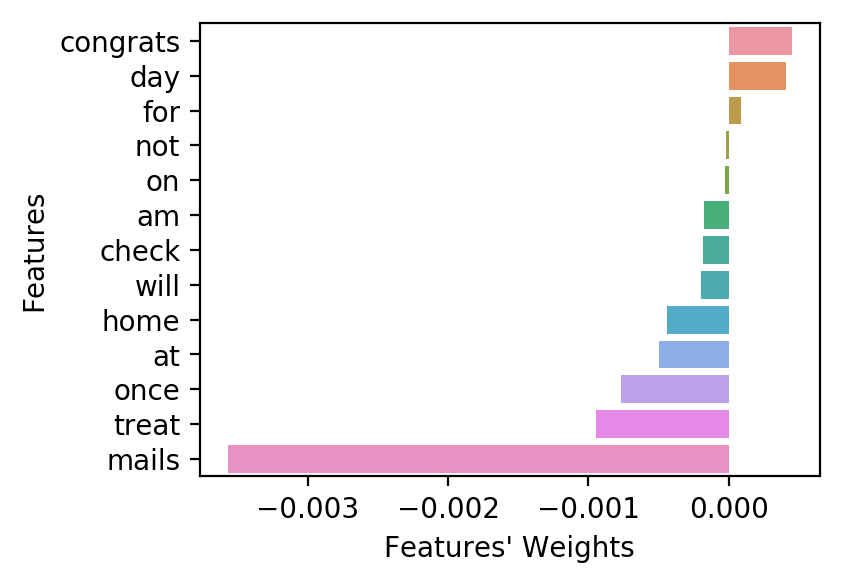

In [59]:
plt.figure(num=None, figsize=(4, 3), dpi=200, facecolor='w', edgecolor='k')
sns.barplot(x="Features' Weights", y="Features", data=model_weights)
#plt.xticks(rotation=90)
#plt.title(str('Features not appearing in the instance'))
plt.show()

Let's see words that are not appearing in this sentence, but appeared in the neighbourhood.

In [60]:
np.argmax(weights),np.argmin(weights),np.max(weights),np.min(weights),vec.get_feature_names()[np.argmax(weights)],vec.get_feature_names()[np.argmin(weights)]

(35, 22, 0.004302129464891401, -0.005810900541025956, 'all', 'ad')

In [71]:
print("Original",lime_predict(['congrat treat pend am not on mail for day wil mail onc thru respect mother at home check mail'])[0][1])
print("Without Congrats",lime_predict(['treat pend am not on mail for day wil mail onc thru respect mother at home check mail'])[0][1])
print("Without mails",lime_predict(['congrat treat pend am not on for day wil onc thru respect mother at home check'])[0][1])
print("With reply",lime_predict(['congrat all treat pend am not on mail for day wil mail onc thru respect mother at home check mail'])[0][1])
print("With ad",lime_predict(['ad congrat treat pend am not on mail for day wil mail ad onc thru respect mother at home check'])[0][1])

Original 0.10271975
Without Congrats 0.10155333
Without mails 0.10357514
With reply 0.10305728
With ad 0.0987237


In [65]:
counter_weights = []
counter_features = []
for i in range(len(weights)):
    if weights[i]!=0:
        if vec.get_feature_names()[i] not in X_train[9]:
            counter_weights.append(weights[i])
            counter_features.append(vec.get_feature_names()[i])
co_weights = pd.DataFrame({"Counter Features": list(counter_features), 
                                  "Features' Weights": list(counter_weights)})
co_weights = co_weights.sort_values(by="Features' Weights", ascending=False)
co_weights = pd.concat([co_weights.head(5),co_weights.tail(5)])
co_weights['Counter Features'][670]='reply'

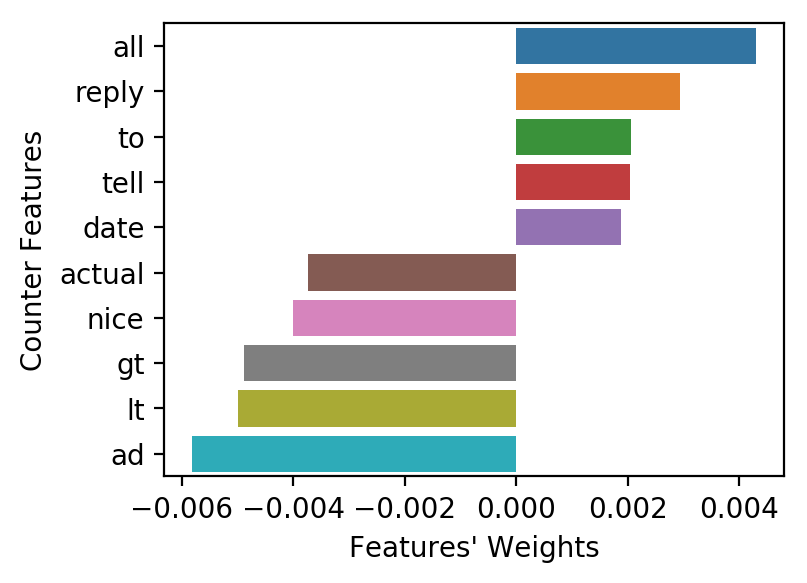

In [66]:
plt.figure(num=None, figsize=(4, 3), dpi=200, facecolor='w', edgecolor='k')
sns.barplot(x="Features' Weights", y="Counter Features", data=co_weights)
#plt.xticks(rotation=90)
#plt.title(str('Features not appearing in the instance'))
plt.show()

However, in another sentence, repli is contributing to the other class

In [82]:
inde = 4249
X_trainR[inde],X_train[inde]

("How did you find out in a way that didn't include all of these details",
 'how did you find out in way that did not includ all of these detail')

In [83]:
weights, real_prediction, local_prediction = lionetWA.explain_instance(x_train[inde].A[0], 7000, transparent_model)

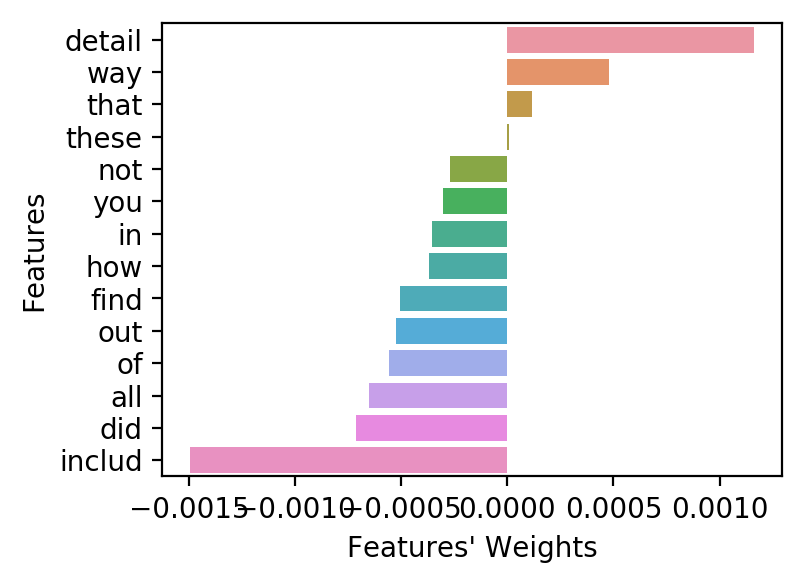

In [84]:
model_weights = pd.DataFrame({"Features": list(vec.get_feature_names()), 
                              "Features' Weights": list(weights*x_train[inde].A[0])})
model_weights = model_weights.sort_values(by="Features' Weights", ascending=False)
model_weights = model_weights[(model_weights["Features' Weights"] != 0)]    
#model_weights, lime_predict([text])[0][1], rd.predict(texts)[0], weights
plt.figure(num=None, figsize=(4, 3), dpi=200, facecolor='w', edgecolor='k')
sns.barplot(x="Features' Weights", y="Features", data=model_weights)
plt.show()

In [85]:
print("Original",lime_predict(['how did you find out in way that did not includ all of these detail'])[0][1])
print("Without all",lime_predict(['how did you find out in way that did not includ of these detail'])[0][1])

Original 0.10125001
Without all 0.102066
